In [1]:
import json
import os
import itertools
import pandas as pd
import numpy as np
import re
from datetime import datetime as dt

import sys
sys.path.append(".\\sample")
from SALibRepastParams import num_levels, params, random_seed, init_problem, calc_second_order, policies

import batch_data_utils as bd_utils

In [2]:
with open(".//config.json") as f:
    config = json.load(f)

In [4]:
file_datetime_string = config['file_datetime_string']
vehicle_density_timestamp = config['vehicle_density_timestamp']
setting = config['setting']

gis_data_dir = os.path.abspath("..\\data\\model_gis_data")
data_dir = config['batch_data_dir']
img_dir = "..\\output\\img\\"

In [5]:
output_paths = bd_utils.get_ouput_paths(file_datetime_string, vehicle_density_timestamp, data_dir)
output_sd_data = output_paths["output_sd_data"]

## Get data to analyse

In [33]:
dfDD = pd.read_csv(output_sd_data)

# get policy parameter and split the data into groups for different policies
policy_param = list(policies.keys())[0]
policy_values = policies[policy_param]
scenario_param_cols =  [i for i in params if i!=policy_param]

# Now group by scenario and aggregate to find difference in outputs between policy conditions
for c in scenario_param_cols:
	dfDD[c] = dfDD[c].astype(str) # Helps with grouping, makes matching doubles easier

dfPolicyDiff = dfDD.groupby(scenario_param_cols).agg( 	PedDistDiff = pd.NamedAgg(column = "DistPAPed", aggfunc=lambda s: s.values[0] - s.values[1]),
														VehDistDiff = pd.NamedAgg(column = "DistPAVeh", aggfunc=lambda s: s.values[0] - s.values[1]),
														PedDurDiff = pd.NamedAgg(column = "DurPAPed", aggfunc=lambda s: s.values[0] - s.values[1]),
														VehDurDiff = pd.NamedAgg(column = "DurPAVeh", aggfunc=lambda s: s.values[0] - s.values[1]),
														CountRuns = pd.NamedAgg(column = "run", aggfunc=lambda s: s.shape[0]),
														RunsStr = pd.NamedAgg(column = "run", aggfunc=lambda s: ":".join(str(i) for i in s.tolist())),
													).reset_index()

for c in scenario_param_cols:
	dfPolicyDiff[c] = pd.to_numeric(dfPolicyDiff[c])

# Check that there are expected number of runs per scenario
assert (dfPolicyDiff['CountRuns']==2).all()

# Identify successfull scenarios, categorise into two groups
#dfPolicyDiff['success'] = dfPolicyDiff.apply(policy_evaluation)
dfPolicyDiff['success'] = (dfPolicyDiff['PedDurDiff'] < 0.3) & (dfPolicyDiff['VehDurDiff']<0) # vehicle wait times reduced and pedestrian wait times not significantly worse
print(dfPolicyDiff['success'].value_counts())

False    7
True     3
Name: success, dtype: int64


## Analyse using tools in ema workbench

In [34]:
import matplotlib.pyplot as plt
from ema_workbench.analysis import prim
import seaborn as sns

assert config['setting'] == 'latin' # expect LH desig to be used when doing SD

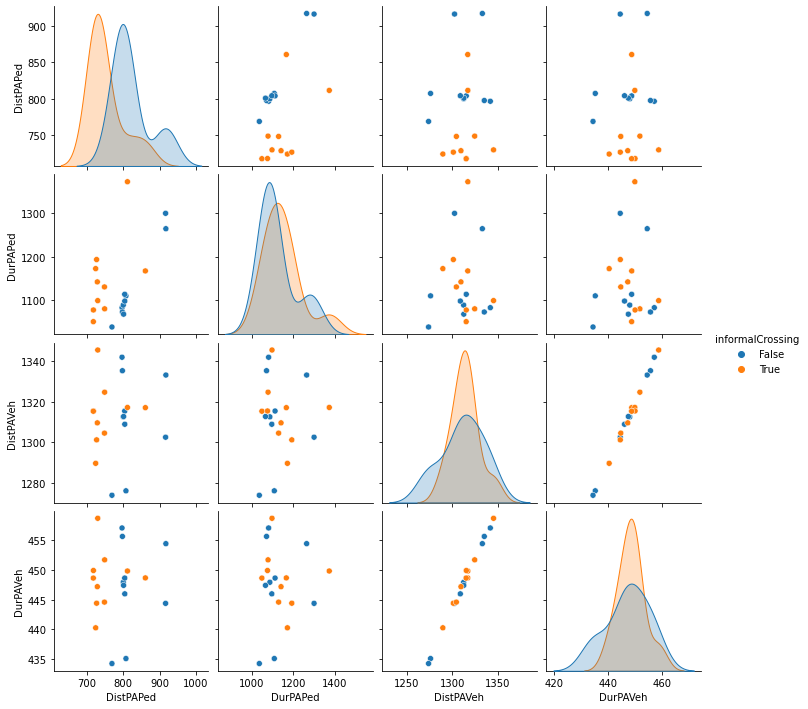

In [35]:
#
# Initial exploratory analysis of multiple outcomes
#

experiments = dfDD.loc[:, params]

outcome_vars = ['DistPAPed','DurPAPed', 'DistPAVeh', 'DurPAVeh']
outcomes = {k:dfDD[k].values for k in outcome_vars}

# Create pairs plot
data = dfDD.loc[:, outcome_vars]
data['informalCrossing'] = experiments['informalCrossing']
sns.pairplot(data, hue='informalCrossing', vars=outcome_vars)

In [48]:
#
# PRIM analysis requires a boolean outcome variable
#

# Identify successfull scenarios, categorise into two groups
dfPolicyDiff['success'] = (dfPolicyDiff['PedDurDiff'] < 0) & (dfPolicyDiff['VehDurDiff']<0) # vehicle and pedestrian wait times reduced
print(dfPolicyDiff.success.value_counts())

# select parameters that actually varied
varied_scenario_param_cols = [i for i in scenario_param_cols if params[i]['type']=='list']

# Now use PRIM to identify what determines policy success/failure most
x = dfPolicyDiff.loc[:, varied_scenario_param_cols].copy()
y = dfPolicyDiff['success'].values

# Round values to make visualisations clearer
for c in ['epsilon','lambda','alpha', 'tacticalPlanHorizon', 'ga']:
	x[c] = x[c].map(lambda x: np.round(x, 4))
    
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

False    7
True     3
Name: success, dtype: int64


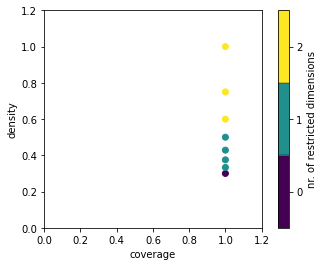

In [49]:
box1.show_tradeoff()
plt.show()

In [50]:
box1.inspect()

coverage    1.0
density     1.0
id            7
mass        0.3
mean        1.0
res_dim       2
Name: 7, dtype: object

           box 7                                         
             min     max                        qp values
lambda   0.53725  1.1566  [0.421875, 0.21599999999999997]
epsilon  5.60405  7.3480                       [1.0, 1.0]



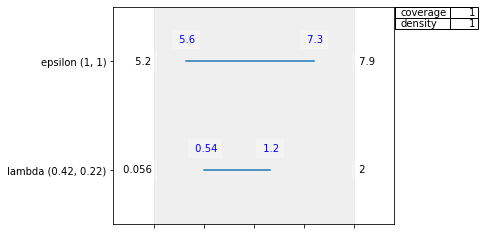

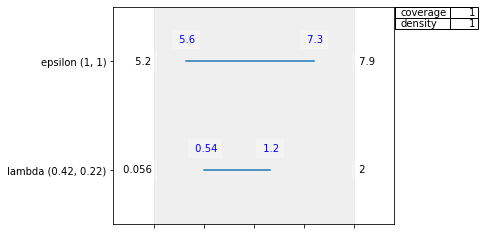

In [51]:
box1.inspect(style='graph')

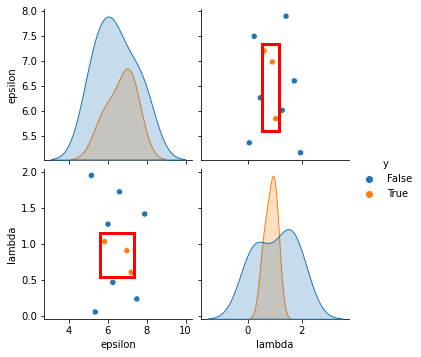

In [52]:
box1.show_pairs_scatter()

In [53]:
box2 = prim_alg.find_box()

In [54]:
box2.show_pairs_scatter()

ValueError: No variables found for grid columns.

#### Repeat PRIM analysis with a different metric pof policy success